In [1]:
from PIL import Image
import sys
import os
import urllib
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
from tf_trt_models.classification import download_classification_checkpoint, build_classification_graph

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
MODEL = 'inception_v1'
CHECKPOINT_PATH = 'inception_v1.ckpt'
NUM_CLASSES = 1001
LABELS_PATH = './data/imagenet_labels_%d.txt' % NUM_CLASSES
IMAGE_PATH = './data/dog-yawning.jpg'

### Download the checkpoint and sample image

In [3]:
checkpoint_path = download_classification_checkpoint(MODEL, 'data')

### Build the frozen graph

In [4]:
frozen_graph, input_names, output_names = build_classification_graph(
    model=MODEL,
    checkpoint=checkpoint_path,
    num_classes=NUM_CLASSES
)






Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from data/inception_v1/inception_v1.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 230 variables.
INFO:tensorflow:Converted 230 variables to const ops.


### Optimized the graph with TensorRT

In [5]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

INFO:tensorflow:Linked TensorRT version: (5, 1, 6)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 6)
INFO:tensorflow:Running against TensorRT version 5.1.6


### Create session and load graph

In [6]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_output = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')

### Download and preprocess image

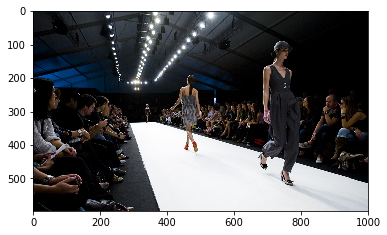

In [13]:
image = Image.open("walk.jpg")

plt.imshow(image)

width = int(tf_input.shape.as_list()[1])
height = int(tf_input.shape.as_list()[2])

image = np.array(image.resize((width, height)))

### Execute model

In [15]:
import time
s=time.time()
output = tf_sess.run(tf_output, feed_dict={
    tf_input: image[None, ...]
})
e=time.time()
print(e-s)
scores = output[0]

0.059020280838012695


### Get top 5 labels

In [16]:
with open(LABELS_PATH, 'r') as f:
    labels = f.readlines()

top5_idx = scores.argsort()[::-1][0:5]

for i in top5_idx:
    print('(%3f) %s' % (scores[i], labels[i]))

(0.312756) stage

(0.045057) ski

(0.025374) fountain

(0.024883) space shuttle

(0.018063) balance beam, beam



### Close session to release resources

In [13]:
tf_sess.close()